<center><font size="6">Project 3: Classifying Reddit Posts - Disney Plus vs Netflix</font></center>
<center>Author : Teo Zhan Rui</center>

<table> <tr ><td bgcolor = "white"><img src="./images/disney+logo.png" style="float: centre; margin: 20px; width, height: 50px"><td bgcolor = "white">     </td>  <td bgcolor = "white"><img src="./images/netflixlogo.png" style="float: right; margin: 20px; width, height: 50px"></td>


image source: <br>
https://en.wikipedia.org/wiki/Netflix <br>
https://en.wikipedia.org/wiki/Disney%2B

# Introduction

This project involves building a classification model to differentiate between Disney Plus and Netflix posts on Reddit. It is then possible for future use in classifying posts that may be scraped from other social media platforms or other related subreddits. These posts may not be explicitedly labelled as a Disney Plus or Netflix related text. 

In the context of Singapore, Netflix has been the incumbent player as the more popular content subscription service.  Disney Plus was launched recently in March 2021 with some of their crowd pullers already well received in the global markets. 

In addition to classification, I will attempt to use natural language processing techniques to discover topics discussed by the Reddit community and follow up with some recommendation for DisneyPlus to gain market share.

## Problem Statement

1) What are the commonly discussed DisneyPlus titles?

2) What are the commonly discussed Netflix titles?

3) What are the negative issues discussed among DisneyPlus subscribers?

## Executive Summary

**Key Findings and Recommendations**
1) Many popular DisneyPlus titles, old and new, are the source of discussion among users which turned out to be top predictors in the classifier. 

- WandaVision
- Raya
- Frozen
- Muppets

2) Netflix produces a very range wide of content which may be the reason why the discussions are not centred about several titles. 

- Stranger Things
- Crime Scene: The Vanishing at the Cecil Hotel
- Legends of Korra


3) Technical issues such as device compatibility, playback and customer service must be addressed in order to reduce customer attrition. 

**Machine Learning Model** <br>
The final production uses Naives Bayes Multinomial Classifier with an accuracy score of 97.88% on the training set and 81.9% on the hold out set (X_test). 

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC    
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, plot_confusion_matrix, plot_roc_curve)

from textblob import TextBlob
import spacy
from collections import Counter
from PIL import Image
import pickle

In [2]:
# custom function for loading raw data, extracting relevant columns, 
# and then writing as csv for future work

def create_df(path):
    df = pd.read_csv(path)
    df = df[['title','selftext', 'subreddit']].fillna(' ')
    # concatenate strings from 'title' and 'selftext' 
    df['post'] = df['title'] + " " + df['selftext']
    cols_drop = [col for col in df.columns if (col != 'post') and (col != 'subreddit')]
    df.drop(columns=cols_drop, inplace = True)
    return df

Webscrapping was performed on a separate notebook. Please refer to 'supplementary-scrape.ipynb'. 

In [3]:
disney = create_df('./datasets/scrape_DisneyPlus.csv')

In [4]:
# check that there is no null value in disney
disney.isnull().sum()

subreddit    0
post         0
dtype: int64

In [5]:
disney.head()

,subreddit,post
0,DisneyPlus,Join the Cordcutting &amp; Streaming TV Discor...
1,DisneyPlus,The Falcon and The Winter Soldier - Episode Di...
2,DisneyPlus,FAWS &amp; Wandavision advertisement at a bus ...
3,DisneyPlus,Disney plus autoplay not working on ps4 Why do...
4,DisneyPlus,Mighty ducks game changers question I’ve yet t...


In [6]:
netflix = create_df('./datasets/scrape_Netflix.csv')

In [7]:
# check that there is no null value in netflix
netflix.isnull().sum()

subreddit    0
post         0
dtype: int64

In [8]:
netflix.head()

,subreddit,post
0,netflix,Netflix now allows you to remove a movie/serie...
1,netflix,"Hi we're Mark, Zach and Broden from Aunty Donn..."
2,netflix,This is a rough month for netflix - almost not...
3,netflix,Dual subtitles? When?! Why not have dual subti...
4,netflix,Why can’t I watch some titles on all devices? ...


# Preprocessing and Feature Engineering

In [9]:
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [10]:
# add subreddit keywords to stopwords
stopwords = stopwords.union({'disney','disneyplus', 'plus', 'watch', 'netflix'})

In [11]:
#check that both subreddit topics are in stopwords
'disneyplus' in stopwords

True

In [12]:
'netflix' in stopwords

True

In [13]:
# custom function to preprocess text
def preprocess(text):
    # create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # generate lemmas
    lemmas = [token.lemma_.lower() for token in doc]
    # remove stopwords and non-alphabetic characters
    alpha_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(alpha_lemmas)

In [14]:
# custom function to preprocess text
def num_words(text):
    words = text.split()
    return len(words)

In [15]:
# custom function to compute polarity of post
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [16]:
# custom function to map numerical polarity to categorical sentiment
def sentiment(x):
    if x>0:
        return 'positive'
    elif x<0:
        return 'negative'
    else:
        return 'neutral'

In [17]:
df = pd.concat([disney, netflix], ignore_index = True)

Examine first post before preprocessing.

In [18]:
df['post'].iloc[0]

'Join the Cordcutting &amp; Streaming TV Discord [Join the Cordcutting &amp; Streaming TV Discord](https://discord.gg/rJxX2cw5Eg)\n\n**The Disney+ Discord Server recently expanded.** We now include channels for other streaming services, including Netflix, Hulu, and Paramount+. To gain access to these channels, you will use our #role-selector channel. Our expansion also invites a new name: **Cordcutting &amp; Streaming TV.**\n\nWe started this discord server in August of 2019, just before the Disney+ launch. Since that time, we have seen our server expand to nearly 2,000 individuals. We have had great conversations about the service, including troubleshooting and content like *The Mandalorian* and *WandaVision.* This Discord is a merger of our current server and those run by partner subreddits. We realize that most of us subscribe to multiple streaming services. A Discord dedicated to each streamer fragments the fandom. This expansion now creates a united community where you can talk wi

In [19]:
df['processed_text'] = df['post'].apply(preprocess)

Examine first post after preprocessing.

In [20]:
df['processed_text'].iloc[0]

'join cordcutting amp streaming tv discord join cordcutting amp streaming tv discord server recently expand include channel streaming service include hulu gain access channel use role selector channel expansion invite new cordcutting amp streaming tv start discord server august launch time server expand nearly individual great conversation service include troubleshooting content like mandalorian wandavision discord merger current server run partner subreddit realize subscribe multiple streaming service discord dedicate streamer fragment fandom expansion create united community talk fan mandalorian picard bridgerton alike gain access channel relevant use role selector channel discord pick channel relevant avoid hope expansion enrich conversation begin discuss streamer like hulu use following link happy watching'

In [21]:
# count number of words in the original post: title + selftext
df['num_words'] = df['post'].apply(num_words)

In [22]:
# compute polarity on the original post
df['polarity'] = df['post'].apply(polarity)

In [23]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [24]:
#Map "subreddit" as 1 for 'DisneyPlus' and 0 for 'netflix'.
df['label'] = df['subreddit'].map(lambda x: 1 if x == 'DisneyPlus' else 0)

In [25]:
df['label'].value_counts()

0    722
1    576
Name: label, dtype: int64

In [26]:
df['label'].value_counts(normalize=True)

0    0.55624
1    0.44376
Name: label, dtype: float64

Baseline accuracy = 54.4%. This is roughly balanced dataset and is not significantly skewed towards either class.

In [27]:
df.head()

,subreddit,post,processed_text,num_words,polarity,sentiment,label
0,DisneyPlus,Join the Cordcutting &amp; Streaming TV Discor...,join cordcutting amp streaming tv discord join...,210,0.189336,positive,1
1,DisneyPlus,The Falcon and The Winter Soldier - Episode Di...,falcon winter soldier episode discussion threa...,134,0.127273,positive,1
2,DisneyPlus,FAWS &amp; Wandavision advertisement at a bus ...,faw amp wandavision advertisement bus stop sin...,10,0.000000,neutral,1
3,DisneyPlus,Disney plus autoplay not working on ps4 Why do...,autoplay work device autoplay work autoplay wo...,50,-0.041667,negative,1
4,DisneyPlus,Mighty ducks game changers question I’ve yet t...,mighty duck game changer question answer episo...,31,0.000000,neutral,1


In [28]:
df.to_csv('./datasets/cleaned.csv', index=False)

# EDA

## Length of Posts

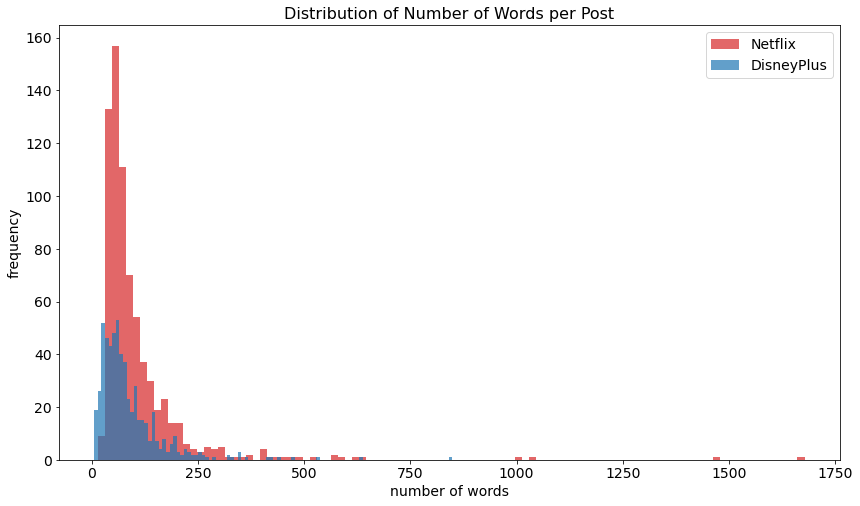

In [29]:
plt.figure(figsize=(14,8))

df[df['subreddit']=='netflix']['num_words'].plot(kind = 'hist', alpha = 0.7, 
                                                color='tab:red', label= 'Netflix', bins = 100)
df[df['subreddit']=='DisneyPlus']['num_words'].plot(kind = 'hist', alpha = 0.7, 
                                                   color='tab:blue', label = 'DisneyPlus', bins = 100);
plt.title('Distribution of Number of Words per Post', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('number of words', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.legend(prop={'size': 14});


Observations:

1) Lengths of posts of each subreddit fall mostly between 20 and 250 words. 

2) There are more Netflix posts which are very longer, compared to DisneyPlus Subreddits.

In [30]:
df[(df['num_words']>500) & (df['subreddit']=='DisneyPlus')][['post']]

,post
87,DisneyPlus is a terrible disappointment for PC...
461,"Looking through ""Pixar Through the Years,"" it ..."
561,Disney-owned content still on HBO / Cinemax / ...


Observations:
    
1) The lengthy DisneyPlus posts appear to be listing many other titles from other content providers. 

In [31]:
df[(df['num_words']>500) & (df['subreddit']=='netflix')][['post']]

,post
601,"Review of ""The One"" Ep. 2 [This](https://www.r..."
742,"Just Watched ""I Care A Lot"" and Cringed So Har..."
839,The Elisa Lam Netflix series is appalling. I s...
873,Defending The Vanishing at the Cecil Hotel Wel...
985,My first impressions on Age of Samurai Battle ...
987,Everything Coming To Netflix In March 2021 # G...
1026,Avatar Legends of Korra.... we really want mor...
1148,The Vanishing at Cecil Hotel is problematic an...
1162,Why the new Ron Howard Crime Scene doc uses a ...
1214,My thoughts about Crime scene: Cecil Hotel I j...


Observations:
    
1) Heated discussion related to 'Crime Scene: The Vanishing at the Cecil Hotel' appears in several lengthy Netflix posts. This title has generated quite some buzz among viewers.
 
2) Discussed titles also include 'Legends of Korra'. One post seeems to be from a subscriber with phone service issue. 

## Word Cloud

In [32]:
disney_alltext = df[df['label']==1]['processed_text'].str.cat(sep=' ')

In [33]:
# custom function to count word occurence
def top_words(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_.lower() for token in doc]
    # Remove stopwords and non-alphabetic characters
    alpha_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    counter = Counter(alpha_lemmas)
    return counter.most_common()

In [34]:
disney_top = top_words(disney_alltext)

In [35]:
disney_top.sort(key=lambda x:x[1], reverse=True)

In [36]:
disney_top

[('episode', 236),
 ('star', 220),
 ('app', 210),
 ('movie', 200),
 ('like', 192),
 ('service', 184),
 ('tv', 168),
 ('know', 168),
 ('device', 159),
 ('content', 150),
 ('try', 141),
 ('issue', 138),
 ('country', 136),
 ('time', 130),
 ('use', 126),
 ('season', 120),
 ('work', 117),
 ('new', 114),
 ('step', 113),
 ('want', 109),
 ('find', 107),
 ('come', 106),
 ('think', 102),
 ('change', 93),
 ('available', 87),
 ('look', 87),
 ('subtitle', 85),
 ('release', 83),
 ('series', 80),
 ('add', 79),
 ('account', 78),
 ('play', 76),
 ('set', 74),
 ('way', 72),
 ('list', 72),
 ('help', 71),
 ('fix', 71),
 ('subscription', 70),
 ('title', 69),
 ('update', 69),
 ('screen', 68),
 ('start', 65),
 ('access', 63),
 ('stream', 63),
 ('year', 63),
 ('original', 60),
 ('month', 60),
 ('film', 60),
 ('hulu', 58),
 ('option', 56),
 ('miss', 55),
 ('good', 54),
 ('thing', 53),
 ('support', 53),
 ('turn', 52),
 ('problem', 52),
 ('wonder', 49),
 ('version', 49),
 ('marvel', 47),
 ('log', 47),
 ('day', 47

In [37]:
netflix_alltext = df[df['label']==0]['processed_text'].str.cat(sep=' ')

In [38]:
netflix_top = top_words(netflix_alltext)

In [39]:
netflix_top.sort(key=lambda x:x[1], reverse=True)

In [40]:
netflix_top

[('like', 441),
 ('movie', 362),
 ('know', 270),
 ('series', 230),
 ('episode', 215),
 ('think', 210),
 ('good', 205),
 ('tv', 178),
 ('time', 178),
 ('season', 172),
 ('use', 168),
 ('try', 160),
 ('find', 157),
 ('thing', 154),
 ('look', 154),
 ('want', 151),
 ('new', 147),
 ('account', 132),
 ('feel', 128),
 ('end', 126),
 ('work', 125),
 ('way', 125),
 ('people', 123),
 ('app', 122),
 ('love', 120),
 ('start', 112),
 ('play', 105),
 ('help', 104),
 ('character', 104),
 ('subtitle', 100),
 ('issue', 94),
 ('happen', 94),
 ('lot', 91),
 ('come', 90),
 ('bad', 88),
 ('english', 87),
 ('film', 86),
 ('thank', 84),
 ('need', 84),
 ('content', 79),
 ('list', 79),
 ('nt', 78),
 ('great', 77),
 ('set', 77),
 ('year', 76),
 ('day', 73),
 ('change', 73),
 ('scene', 71),
 ('story', 71),
 ('title', 70),
 ('documentary', 70),
 ('video', 66),
 ('tell', 66),
 ('original', 66),
 ('finish', 65),
 ('talk', 65),
 ('guy', 65),
 ('long', 64),
 ('email', 64),
 ('hotel', 64),
 ('profile', 61),
 ('old', 6

In [41]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(36, 24))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

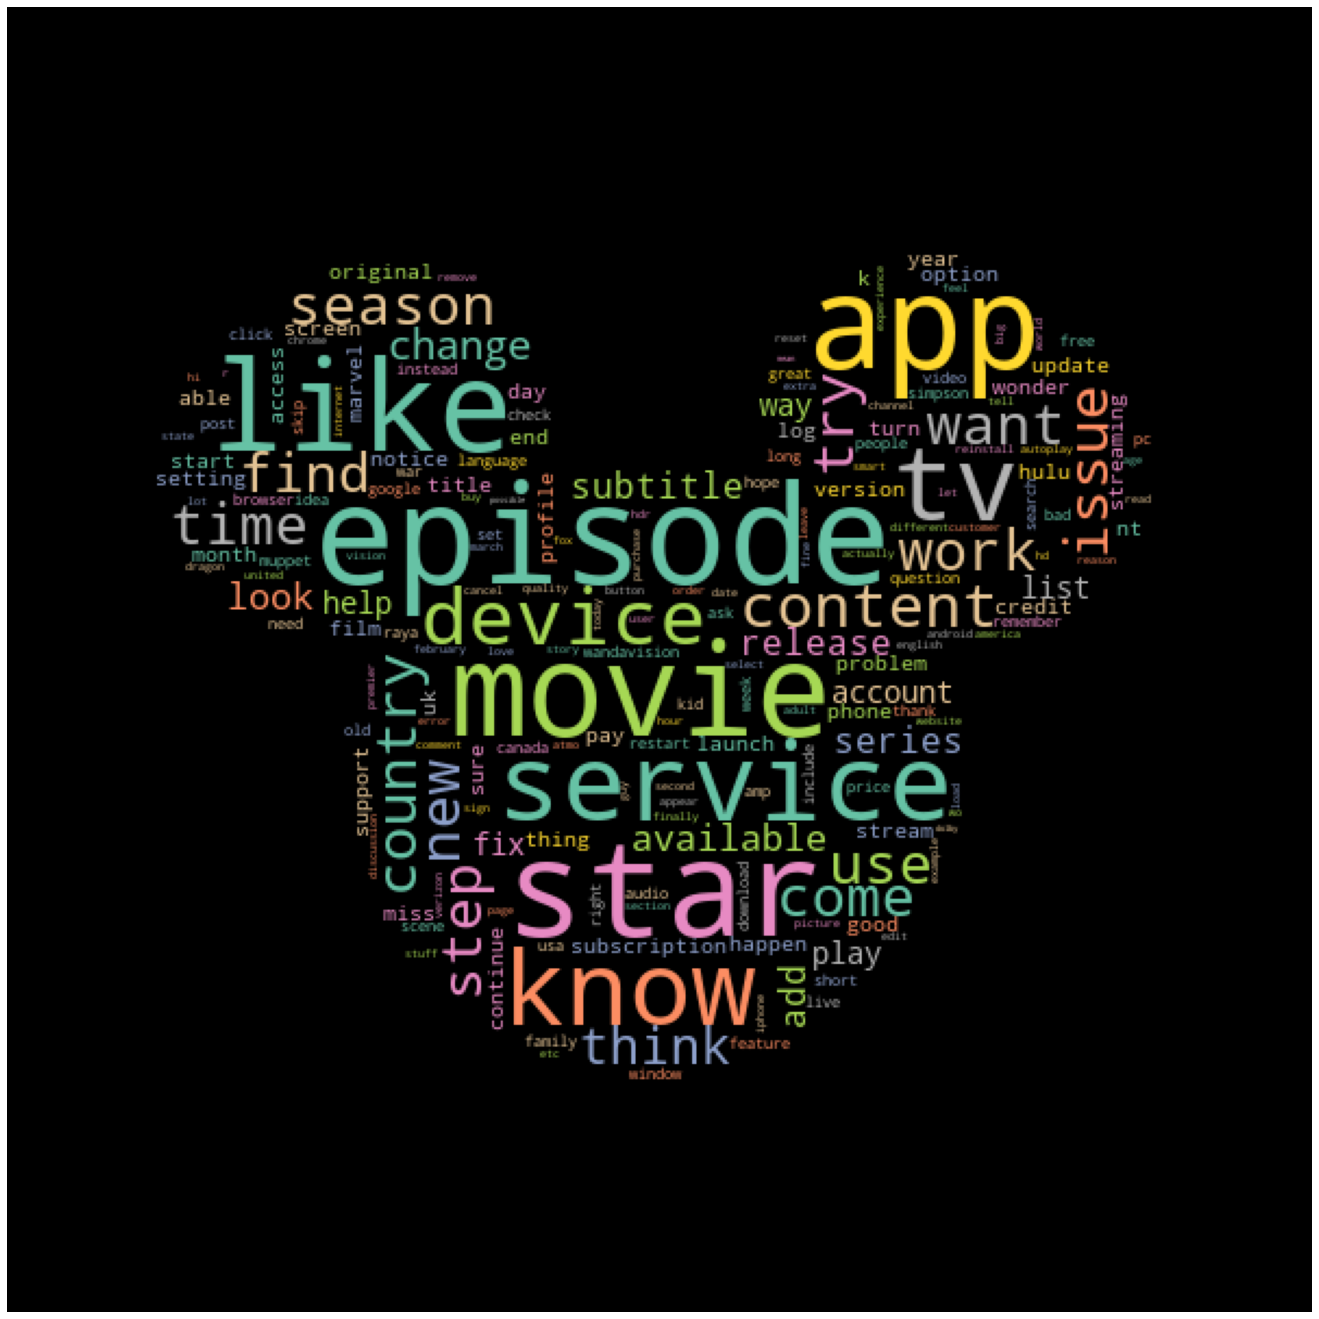

In [42]:
mask = np.array(Image.open('./images/disney_mask.jpg'))
# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', \
                      colormap='Set2', collocations=False, stopwords = stopwords, \
                      mask=mask).generate(disney_alltext)
# Plot
plot_cloud(wordcloud)

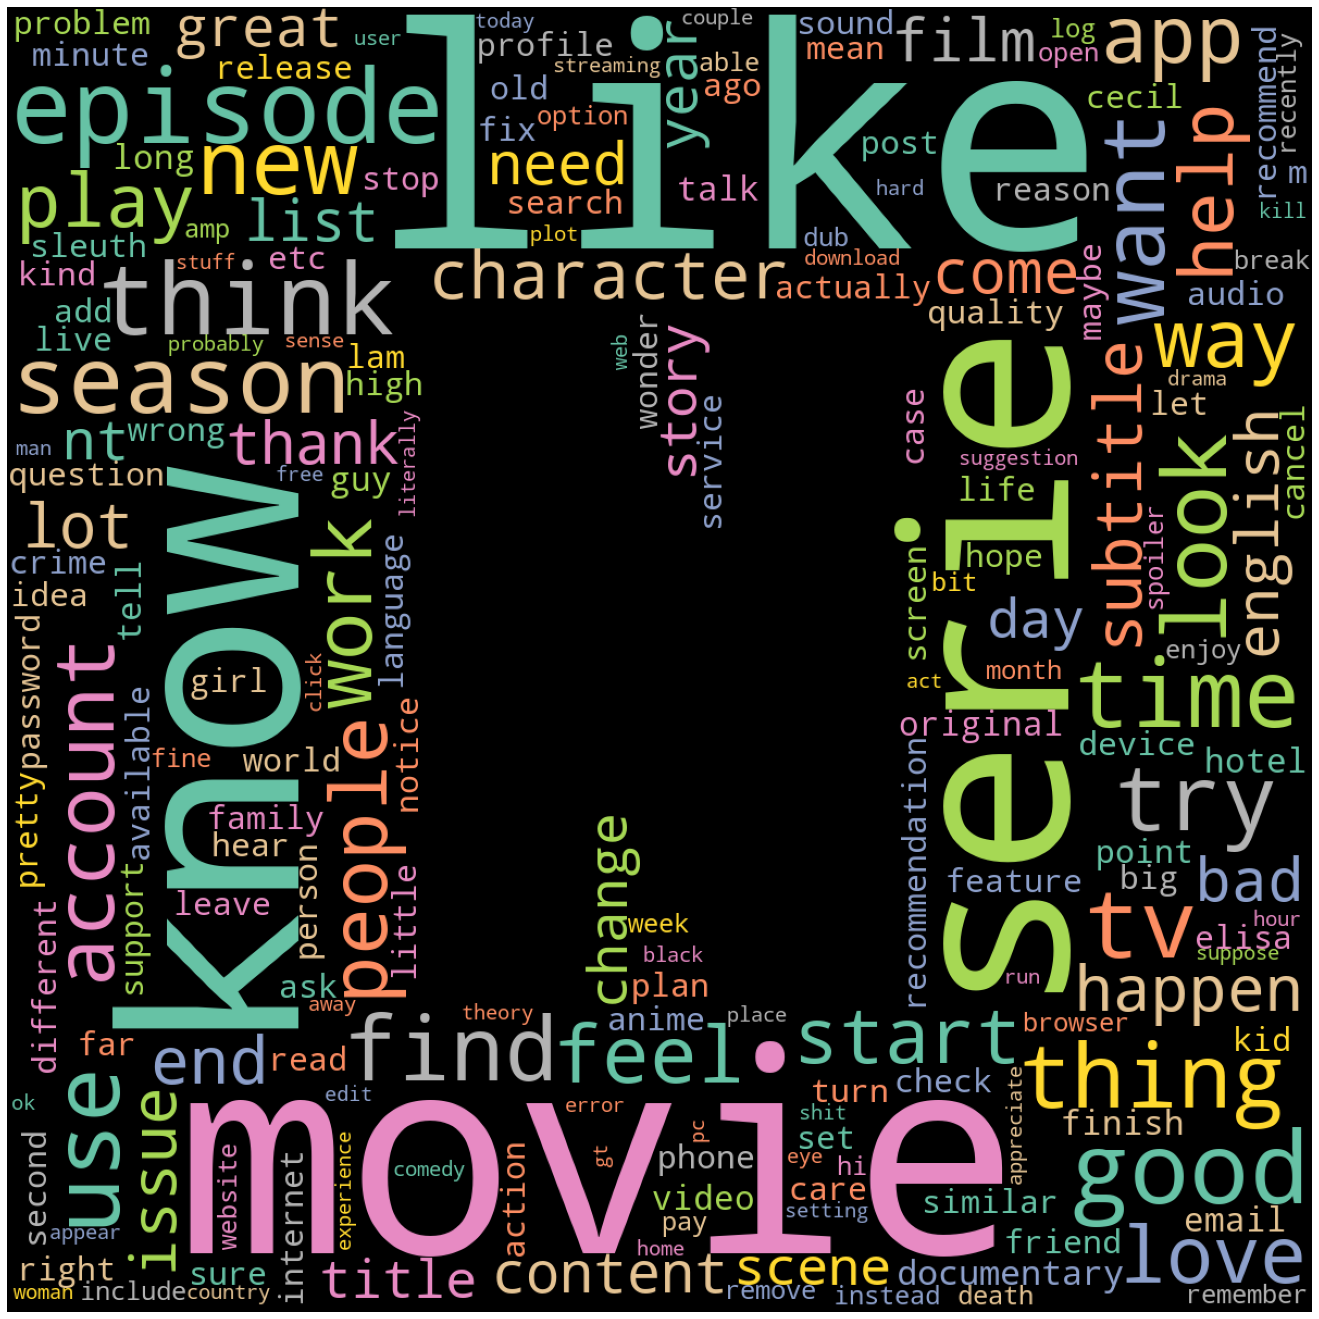

In [43]:
mask = np.array(Image.open('./images/netflix_mask.jpg'))
# Generate wordcloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', \
                      colormap='Set2', collocations=False, stopwords = stopwords, \
                      mask=mask).generate(netflix_alltext)
# Plot
plot_cloud(wordcloud);

Observation:
  
From the 2 word clouds, there are many single words common to both subreddits and closely related to video streaming, such as 'episodes','movie','tv' etc. Verbs like 'feel', 'like' and 'want' give some clue that much of the discussion involves like or dislike of content or service. 

## N-grams

In [44]:
# vectorizer for n-grams
def ngram(series, n = 1):
    cvec2 = CountVectorizer(ngram_range=(n,n)).fit(series)
    bag = cvec2.transform(series)
    # sum columns to obtain occurence count
    count = bag.sum(axis=0)
    # match count to vocabulary
    word_freq = [(word, count[0, i]) for word, i in cvec2.vocabulary_.items() ]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq

**Unigrams**

In [45]:
unigrams = ngram(df['processed_text'], 1)

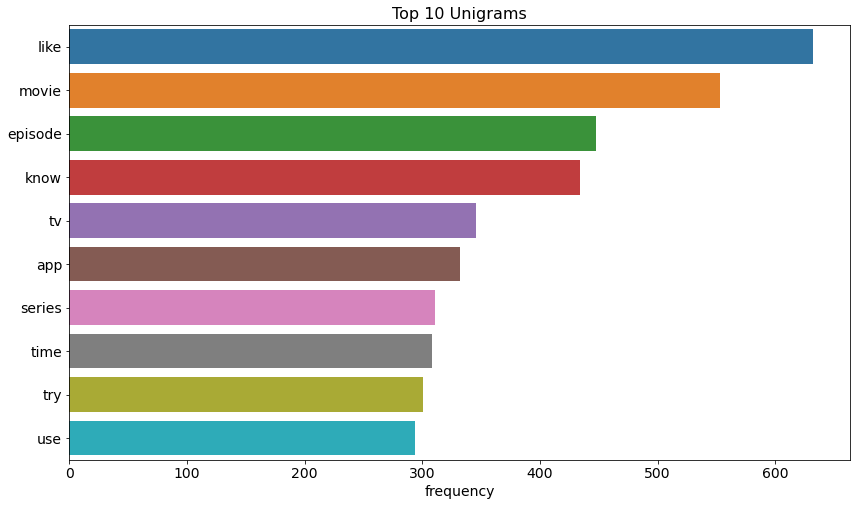

In [46]:
phrase, freq= map(list,zip(*unigrams[:10]))
plt.figure(figsize=(14,8))
sns.barplot(x=freq,y=phrase)

plt.title('Top 10 Unigrams', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('frequency', fontsize=14);

**Bigrams**

In [47]:
bigrams = ngram(df['processed_text'], 2)

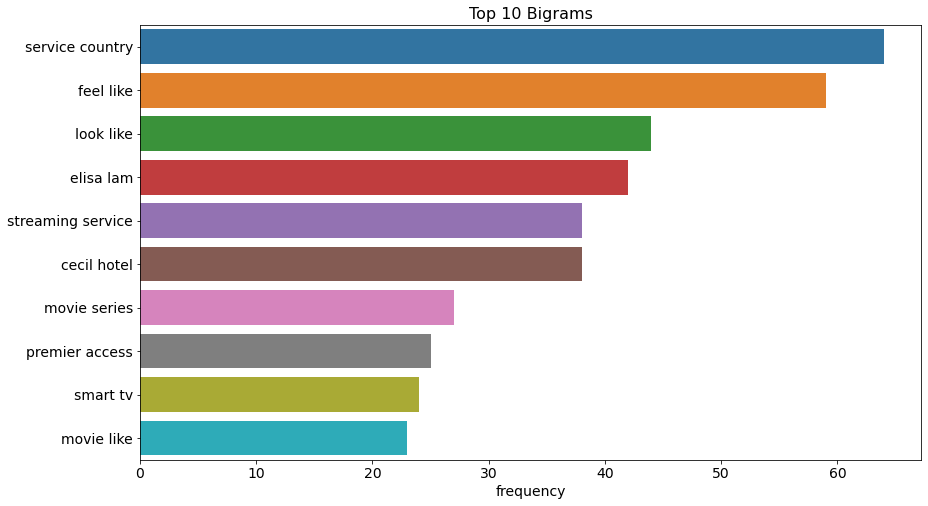

In [48]:
phrase, freq= map(list,zip(*bigrams[:10]))
plt.figure(figsize=(14,8))
sns.barplot(x=freq,y=phrase)

plt.title('Top 10 Bigrams', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('frequency', fontsize=14);

In [49]:
df[df['processed_text'].str.contains('service country')]

,subreddit,post,processed_text,num_words,polarity,sentiment,label
20,DisneyPlus,Volume issues I'm currently watching the falco...,volume issue currently falcon ws volume extrem...,91,-0.096429,negative,1
24,DisneyPlus,Language option menu invisible when playing a ...,language option menu invisible play movie stic...,70,0.000000,neutral,1
41,DisneyPlus,Samsung TV app not working ( blank screen ) \n...,samsung tv app work blank screen issue access ...,349,0.090068,positive,1
42,DisneyPlus,Sound delay issue I haven’t been able to find ...,sound delay issue able find regard device serv...,61,0.191667,positive,1
55,DisneyPlus,Can you change subtitle font size on the PS4? ...,change subtitle font size way change font size...,39,0.000000,neutral,1
...,...,...,...,...,...,...,...
540,DisneyPlus,Can't cast to TV with build-in Chromecast Devi...,cast tv build chromecast device toshiba smart ...,63,0.182143,positive,1
547,DisneyPlus,"I can't group watch Wall-E, I wanted to know i...",group wall e want know specific reason try gro...,130,-0.152083,negative,1
556,DisneyPlus,Continue Watching feature doesn't work at all....,continue feature work hey laptop chrome delete...,292,0.097595,positive,1
562,DisneyPlus,"Stuttering on NVIDIA Shield TV Hi,\n\nI'm expe...",stutter nvidia shield tv hi experience odd iss...,167,-0.015833,negative,1


Observations:
    
1) Posts containing 'service country' are all bringing up playback issues specific to DisneyPlus. Also many devices used for viewing were mentioned, such as Playstation, Chrome Cast and Apple TV.

2) These posts are generally complaints about technical issues but do not necessarily display negative sentiments. The off-the-shelf polarity commputation from textblob may not be suitable in such cases. 

**Trigrams**

In [50]:
trigrams = ngram(df['processed_text'], 3)

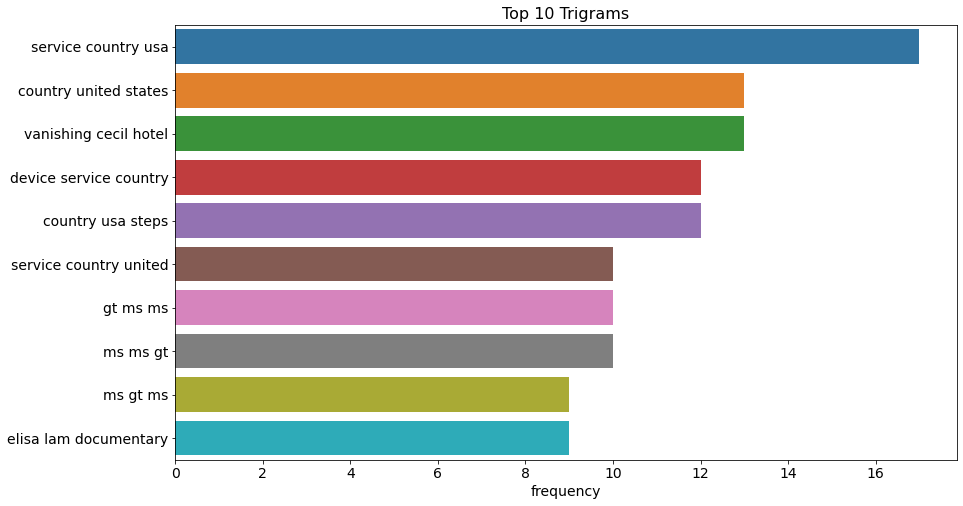

In [51]:
phrase, freq= map(list,zip(*trigrams[:10]))
plt.figure(figsize=(14,8))
sns.barplot(x=freq,y=phrase)

plt.title('Top 10 Trigrams', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('frequency', fontsize=14);

Observations: 
    
1) 'Vanishing Cecil Hotel' points to 'Crime Scene: The Vanishing at the Cecil Hotel' which is a Netflix production. 
It is likely to be content of sufficient popularity to appear at a top ranked trigram. 

2) Interestingly, USA appeared in several permutations. 

In [52]:
pd.set_option("display.max_colwidth", None)

df[df['processed_text'].str.contains('service country usa')]

,subreddit,post,processed_text,num_words,polarity,sentiment,label
24,DisneyPlus,"Language option menu invisible when playing a movie, now stuck on multiple languages from trying to fix * Device: Apple TV A1625\n* Service: Disney+\n* Country: USA\n* Steps Taken: I've checked for updates, restarted the Apple TV, I was going to try to uninstall and reinstall Disney+ but I can't uninstall it for some reason, and I looked around on Google for any similar issues but found nothing.",language option menu invisible play movie stick multiple language try fix device apple tv service country usa step check update restart apple tv try uninstall reinstall uninstall reason look google similar issue find,70,0.000000,neutral,1
41,DisneyPlus,"Samsung TV app not working ( blank screen ) \nI've been having issues accessing Disney+ last Sunday. Whenever I tried to access the app directly from the tv, it loads into a blank screen. \nUsing the back button to pull out the left dashboard, I was only able to go to the main profile page but every time I tried to access to the main page, blank. It's like all the features in main page are missing. Also whenever I tried a search feature, I'm only able to type up to two letters or numbers only. I also am not able to create a new profile because the avatars are missing. \n\nI was however able to access the feature whenever I however my control in the Disney + app on my home screen on TV. \n\nSo far I've called Samsung 4 times, from clearing the cache by the tech support to resetting the smart hub to adding a new DNS number on my TV. All of them work and I get my home screen back. But it's whenever I turn off my TV or exit the app on my TV, and back again, it goes blank. Everytime. \n\nI called Disney+ and for two hours, the customer SVC officer was talking to the tech support and back and still nothing. Unplugged the tv while it's on and unplugged router. Waited 5 minutes and still nothing. \n\nSo the only thing that works now is if I delete the app and reinstalled back on the tv. But the minute I turned the TV off, and back on, screen is blank. Disney + works fine on my computer and phone. Works fine with Roku app. I checked to see if the other apps on Samsung are having the issues, including the preinstalled ones, all are working fine. Just this one app. Any one having the same issue?? \n\n*Device: 65 inch Samsung UHD 800D model\n*Service: Disney+\n*Country: USA, NY\n*Steps taken: called Samsung multiple times from clearing cache to resetting smart hub to calling Disney+ to adding new DNS number in my TV.",samsung tv app work blank screen issue access sunday try access app directly tv load blank screen use button pull left dashboard able main profile page time try access main page blank like feature main page miss try search feature able type letter number able create new profile avatar miss able access feature control app home screen tv far samsung time clear cache tech support reset smart hub add new dns number tv work home screen turn tv exit app tv blank everytime hour customer svc officer talk tech support unplugged tv unplugged router wait minute thing work delete app reinstall tv minute turn tv screen blank work fine computer phone work fine roku app check app samsung issue include preinstalle work fine app issue device inch samsung uhd model service country usa ny step samsung multiple time clear cache reset smart hub add new dns number tv,349,0.090068,positive,1
189,DisneyPlus,"Every few minutes, the screen turns white and reloads the website. Device: 2018 Macbook Pro\n\nService: Disney+\n\nCountry: USA\n\nSteps Taken: If I reload the website myself, it stops the problem for about an hour.",minute screen turn white reload website device macbook pro service country usa steps reload website stop problem hour,35,-0.100000,negative,1
218,DisneyPlus,Pause doesn't work on Apple TV Disney plus app Device: Apple TV\n\n\n Service: Disney plus\n\n\n Country: USA\n\n\nSteps Taken: searched settings for fire 

Observations:
    
Once again, all posts containing "service country usa" concern technical issues faced by DisneyPlus viewers, which is a cause for concern.

In [53]:
df[df['processed_text'].str.contains('ms gt')]

,subreddit,post,processed_text,num_words,polarity,sentiment,label
798,netflix,"Issue Loading Netflix on Wifi(WOW) Hi, so I have been having issues loading Netflix and Fast.com through my internet, have this issue network wide. Everything else such as Prime, Youtube and Hulu play just fine. My internet speed is 100 down. \n\nWhat works right now, is that I use (redacted) to load up a video and then close the (redacted) connection, my wifi is able to buffer the video just fine after the initial connection. When I move on to the next episode, I have to reconnect to (redacted) to start the video. \n\n** I have tried following things: **\n- Reset modem(Arris SB6190) and router(Netgear R6400)\n- Switch DNS from automatic to Google and Cloudflare\n- Restart both modem and router\nIt's been an ongoing issue for couple months now. \n\nTracert report: \n\nTracing route to netflix.com [54.237.226.164]\nover a maximum of 30 hops:\n&gt; 1 &lt;1 ms &lt;1 ms &lt;1 ms 192.168.1.1\n\n&gt; 2 * 11 ms 13 ms d28-23-1-64.dim.wideopenwest.com [23.28.64.1]\n\n&gt; 3 9 ms 9 ms 19 ms 10.52.148.96\n\n&gt; 4 12 ms 9 ms 10 ms 76-73-165-202.knology.net [76.73.165.202]\n\n&gt; 5 10 ms 10 ms 13 ms 23-28-210-80.static.evv.wideopenwest.com [23.28.210.80]\n\n&gt; 6 18 ms 17 ms 17 ms dynamic-75-76-35-51.knology.net [75.76.35.51]\n\n&gt; 7 19 ms 17 ms 19 ms static-76-73-191-230.knology.net [76.73.191.230]\n\n&gt; 8 19 ms * 32 ms 99.83.70.232\n\n&gt; 9 18 ms 28 ms 25 ms 150.222.76.149\n\n&gt; 10 * 19 ms 18 ms 52.95.63.147\n\n&gt; 11 * * * Request timed out.\n\n&gt; 12 * * * Request timed out.\n\n&gt; 29 * * * Request timed out.\n\n&gt; 30 * * * Request timed out.\n\n\n\nMy netflix account seems to be fine, because I can use netflix just fine on mobile data or through other means. ISP = Wide Open West\n\nPingPlotter: https://share.pingplotter.com/91kiScToWia",issue loading hi issue load internet issue network wide prime youtube hulu play fine internet speed work right use redact load video close redact connection wifi able buffer video fine initial connection episode reconnect redact start video try follow thing reset switch dns automatic google cloudflare restart modem router ongoing issue couple month tracert report trace route maximum hop gt ms ms ms gt ms ms gt ms ms ms gt ms ms ms gt ms ms ms gt ms ms ms gt ms ms ms gt ms ms gt ms ms ms gt ms ms gt request time gt request time gt request time gt request time account fine use fine mobile datum mean isp wide open west pingplotter,296,0.131455,positive,0


Observations: 
On further inspection, "gt ms" comes from user complaining of network issues. There can be brought up to the technical team for resolving.

## Sentiment Analysis

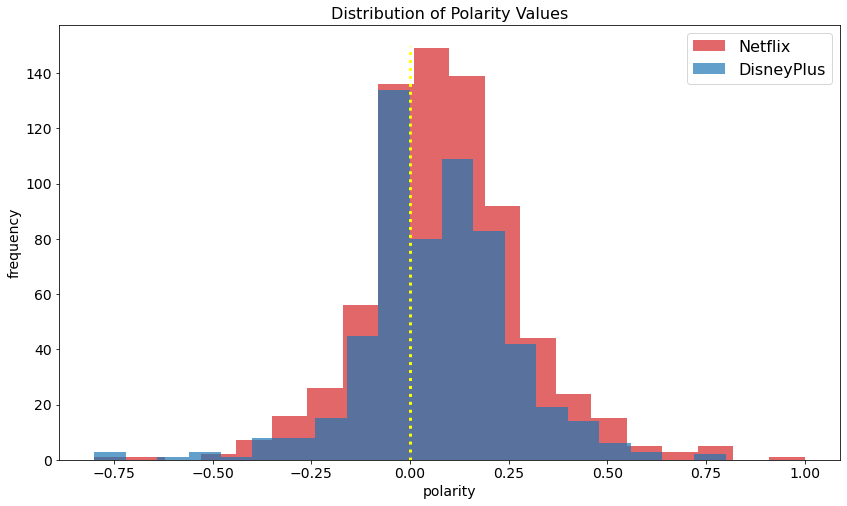

In [54]:
plt.figure(figsize=(14,8))
df[df['subreddit']=='netflix']['polarity'].plot(kind = 'hist', alpha = 0.7, 
                                                color='tab:red', label= 'Netflix', bins = 20)
df[df['subreddit']=='DisneyPlus']['polarity'].plot(kind = 'hist', alpha = 0.7, 
                                                   color='tab:blue', label = 'DisneyPlus', bins = 20);
plt.title('Distribution of Polarity Values', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('polarity', fontsize=14);
plt.ylabel('frequency', fontsize=14);
plt.legend(prop={'size': 16})
plt.vlines(x=0,ymin=0, ymax=150, linestyle='dotted', colors='yellow', lw = 3);

**Observation:**

1) The proportions of posts are from Netflix and DisneyPlus are 54% and 46% respectively. 
At a glance, the bins are of higher heights for Netflix due to higher counts. 

2) It is worth noting that there are some DisneyPlus posts with more negative sentiments than those of Netflix. This will be explored further after model training. 

**Top Positive Posts**

In [55]:
df[df['polarity'] > 0.7]

,subreddit,post,processed_text,num_words,polarity,sentiment,label
388,DisneyPlus,Why doesn’t the Star Wars section have them ordered by timeline? The marvel section has it and it’s a great feature,star wars section order timeline marvel section great feature,21,0.800,positive,1
469,DisneyPlus,"Princess Diaries TV series If the Percy Jackson series is successful as a faithful adaptation, Disney should make a TV show based on The Princess Diaries that also adapts one book per season. And maybe Anne Hathaway can play Mia’s mother. Any suggestions?",princess diaries tv series percy jackson series successful faithful adaptation tv base princess diaries adapt book season maybe anne hathaway play mia mother suggestion,43,0.750,positive,1
681,netflix,BEST! Horror movies on netflix This list includes\nCreep 2\nThe conjuring\nHell fest etc\nI appreciate yall who check it out! Whats YOUR! Favorite horror film on netflix?\nhttps://youtu.be/B5wsJ230s7k,best horror movie list include creep conjure hell f etc appreciate y check s favorite horror film,30,0.750,positive,0
703,netflix,"Kipo and the age of wonderbeasts is an awesome show!!! That's it. That's the post.\n\nBut this sub is forcing me to write a bit more in this part to post this, so I'm gonna say it again. Kipo and the age of wonderbeasts is a very cool show. It's just... awesome! Everything from the music, the animation, the story, everything is awesome! \n\nI hope that's 150 words...",kipo age wonderbeast awesome post sub force write bit post gon na kipo age wonderbeast cool awesome music animation story awesome hope word,68,0.791,positive,0
894,netflix,"The best korean movies on netflix (recommendation request) Hi. Can anyone recommend me good korean movies on netflix? I don’t mind if it’s crime/thriller, sci-fiction or romance/comedy. Any suggestions are welcome :))",good korean movie recommendation request hi recommend good korean movie mind crime thriller sci fiction romance comedy suggestion welcome,32,0.750,positive,0
1015,netflix,"Can't install the Netflix app a Hey there! Is there anybody who can help me about Netflix ? I can't install the app on my phone , in the AppStore I'm told that my phone doesn't support them ! I'm from Portugal and I own a Galaxy Note 9! Any advice ? Thank you 🤍",install app hey anybody help install app phone appstore tell phone support portugal galaxy note advice thank,55,0.750,positive,0
1049,netflix,"Netflix party for mobile So I know Netflix party is a chrome extension, but I also know there are apps and things so you can watch shows with people on mobile. Does anyone have a recommendation for which one I should try like which one works best and maybe is safer?",party mobile know party chrome extension know app thing people mobile recommendation try like work good maybe safe,51,1.000,positive,0
1225,netflix,"Netflix Lego project - support If you could, please support this awesome project, not mine!! :)\n\n&amp;#x200B;\n\n[https://ideas.lego.com/projects/79cd0b37-10db-4ded-9f90-5c03d18edc81](https://ideas.lego.com/projects/79cd0b37-10db-4ded-9f90-5c03d18edc81)",lego project support support awesome project,18,0.750,positive,0


**Most Negative Posts**

In [56]:
df[df['polarity'] < -0.5]

,subreddit,post,processed_text,num_words,polarity,sentiment,label
83,DisneyPlus,"Disney through the decades I feel like this is a stupid question, but did DisneyPlus remove Disney through the decades at some point? It doesn't show up in the collections on my firestick and when I try to pull it up on my PC it just gives me page not found.",decade feel like stupid question remove decade point collection firestick try pull pc page find,51,-0.800,negative,1
236,DisneyPlus,Where’s Disney+‘a schedule? I recall seeing a schedule for all the upcoming originals (it was realized during an event that took place a couple days ago) and I cannot seem to find it now :(.,schedule recall schedule upcoming original realize event place couple day ago find,35,-0.750,negative,1
462,DisneyPlus,Release day in Turkey? Does anyone know when we can use Disney+? I heard they’ll publish it on 23rd of February but there is no official information. I’m from Turkey and I’m desperately waiting for it. It has been 1 year…,release day turkey know use hear publish february official information turkey desperately wait year,41,-0.600,negative,1
502,DisneyPlus,"Premier Access pricing for Latin America. Mexico: [MXN $329](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=242f7b14db316c58d5cdeacb13961989)\n\nArgentina: [1,050 ARS](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=269ef3d8dbfd2c58d5cdeacb13961980)\n\nColombia: [49,900 COP](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=18f0c06cdb716c58d5cdeacb139619d9)\n\nChile: [12,900 CLP](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=a20184acdb716c58d5cdeacb13961956)\n\nBrazil: [69.90 BRL](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=3fbefb9cdbfd2c58d5cdeacb139619c3)\n\nPeru: [54.90 PEN](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=6c21ccacdb716c58d5cdeacb139619ab)\n\nUruguay: [US $16.99](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=451248a8dbb16c58d5cdeacb139619f4)\n\nEcuador: [US $12.99](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=905280acdbb16c58d5cdeacb13961952)\n\nCosta Rica: [US $11.99](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=b55fb3d4db316c58d5cdeacb1396196f)\n\nVenezuela, Dominican Rep, Panama, Paraguay, Nicaragua, Honduras, Guatemala, El Salvador, Bolivia &amp; Belize: [US $13.99](https://help.disneyplus.com/csp?id=csp_article_content&amp;sys_kb_id=0a6248acdbb16c58d5cdeacb1396193a)",premier access pricing latin america mexico mxn argentina colombia chile brazil peru uruguay ecuador costa rica venezuela dominican rep panama paraguay nicaragua honduras guatemala el salvador bolivia amp belize,49,-0.750,negative,1
715,netflix,[PC] [Chrome] How do I hide/blur the episode's synopsis whenever I pause the video? Is there like a google chrome extension that has this feature? I tried searching but I can't find any. It's really annoying when I accidentally read the spoiler of what happen,pc chrome hide blur episode synopsis pause video like google chrome extension feature try search find annoying accidentally read spoiler happen,45,-0.800,negative,0
1082,netflix,"I'd like Netflix show suggestions I'm almost done with Stranger Things and was hoping for show suggestions to watch. I plan to watch Umbrella Academy as well. Nothing worse than TV14 please and preferably no solely comedy, thank you!!",like suggestion stranger things hope suggestion plan umbrella academy bad preferably solely comedy thank,39,-0.625,negative,0


Observations:

1) Polarity is largely affected by single positive words such as "good", "best", "love" and negative words such as "annoying", "worse", "stupid".

2) However the overall sentiment expressed by the writer can be the exact opposite or just neutral. For a reddit user asked for recommendation after watching "Stranger Things" but used the word "worse" which drove the polarity down. 

# Preliminary Exploration of Various Classifiers

In [57]:
X = df['processed_text']
y = df['label']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = y)

I will train the following classifiers using their **default** settings and attempt to select the best 2 classifiers for further refinement. For each model, 2 types of text transformation, count and tfidf vectorizers are used to perform preprocessing. 

In [59]:
# generate dictionary for text transformers and classifiers respectively.
text_dict = {'cvec': CountVectorizer(), 
             'tvec': TfidfVectorizer()}

clf_dict = {
            'lr': LogisticRegression(), 
            'knn': KNeighborsClassifier(),
            'nb': MultinomialNB(),
            'dt': DecisionTreeClassifier(random_state = 42),
            'rf': RandomForestClassifier(random_state = 42),
            'et': ExtraTreesClassifier(random_state = 42),
            'svm': SVC()
           }

In [60]:
# create empty list to store pipelines
pipes = []
# loop to append all combinations of text transformers and classifiers
for i, j in clf_dict.items():
    for x, y in text_dict.items():
        pipe=[]
        pipe = [(x,y),(i,j)]
        pipes.append(pipe)
pipes

[[('cvec', CountVectorizer()), ('lr', LogisticRegression())],
 [('tvec', TfidfVectorizer()), ('lr', LogisticRegression())],
 [('cvec', CountVectorizer()), ('knn', KNeighborsClassifier())],
 [('tvec', TfidfVectorizer()), ('knn', KNeighborsClassifier())],
 [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 [('cvec', CountVectorizer()),
  ('dt', DecisionTreeClassifier(random_state=42))],
 [('tvec', TfidfVectorizer()),
  ('dt', DecisionTreeClassifier(random_state=42))],
 [('cvec', CountVectorizer()),
  ('rf', RandomForestClassifier(random_state=42))],
 [('tvec', TfidfVectorizer()),
  ('rf', RandomForestClassifier(random_state=42))],
 [('cvec', CountVectorizer()), ('et', ExtraTreesClassifier(random_state=42))],
 [('tvec', TfidfVectorizer()), ('et', ExtraTreesClassifier(random_state=42))],
 [('cvec', CountVectorizer()), ('svm', SVC())],
 [('tvec', TfidfVectorizer()), ('svm', SVC())]]

In [61]:
# custom function to print accuracy scores on train and test sets respectively
def scorer(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_score = round(model.score(X_train, y_train),3)
    test_score = round(model.score(X_test, y_test),3)
    # in addition to scores, append to lst the aliases of sklearn models used
    lst=[model.steps[0][0], model.steps[1][0], train_score, test_score]
    return lst

In [62]:
# append result from each model to list
prelim_results = []
for pipe in pipes:
    result = scorer(Pipeline(pipe), X_train, X_test, y_train, y_test)
    prelim_results.append(result)

In [63]:
# create dataframe from prelim_results
prelim_df = pd.DataFrame(prelim_results, columns=['vectorizer','classifier', 'train_score', 'test_score'])

In [64]:
# compute new column for difference between train and test scores to check for overfitting
prelim_df.loc[:,['diff']] = prelim_df['train_score'] - prelim_df['test_score']

In [65]:
prelim_df

,vectorizer,classifier,train_score,test_score,diff
0,cvec,lr,1.000,0.796,0.204
1,tvec,lr,0.932,0.823,0.109
2,cvec,knn,0.558,0.508,0.050
3,tvec,knn,0.844,0.750,0.094
4,cvec,nb,0.921,0.758,0.163
5,tvec,nb,0.942,0.835,0.107
6,cvec,dt,1.000,0.731,0.269
7,tvec,dt,1.000,0.758,0.242
8,cvec,rf,1.000,0.823,0.177
9,tvec,rf,1.000,0.792,0.208


**Observations:** 

From the initial fit with default parameters on all 6 models, K-Nearest Neighbor* perform poorly compared to the rest, quite possibly due to the high number of dimensions and sparsity in the entire matrix. The number of features goes into the range of 30000 with bi-gram included and so the features with low occurences add a lot of noise. 

Tree based models overfit to train set and show significantly lower accuracy on test set. Specifically, Decision Tree Classifier fits to the train set to perfection but performs poorly on test set. 

I will explore 3 distinctively different models. I choose those with lowest overfitting, meaning the smallest difference between train and test score. 

# Model Training and Hyperparameters Tuning

In [66]:
# custom function for grid search CV
def grid_tuning(estimator, params, X_train, X_test, y_train, y_test):   
    #Perform tuning
    gs = GridSearchCV(estimator = estimator,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5,
                        verbose = 2,
                        n_jobs = -1)
    gs.fit(X_train, y_train)
    return gs

## TFIDF Vectorizer and Logistic Regression

In [67]:
pipe1 = Pipeline([
                ('tvec', TfidfVectorizer()),
                ('lr', LogisticRegression())
                 ])

In [68]:
pipe1.get_params();

In [69]:
# original grid search parameter commented out to reduce run time when reloading notebook
params1 = {
    'tvec__max_df': [0.80],
    # 'tvec__max_df': [0.80 ,0.90, 0.95, 1.00],
    'tvec__min_df': [0.00],
    # 'tvec__min_df': [0.00, 0.05, 0.10],
    'tvec__max_features': [None],
    # 'tvec__max_features': [10000, 15000, 20000, None],
    'tvec__ngram_range': [(1,2)],
    # 'tvec__ngram_range': [(1,1),(1,2)],
    'lr__penalty': ['l2'],
    #'lr__penalty': ['l1','l2'],
    'lr__C': [100.0],
    # 'lr__C': np.logspace(-2,2,15),
    'lr__max_iter': [1000]
}

In [70]:
gs1 = grid_tuning(pipe1, params1, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


In [71]:
model1 = gs1.best_estimator_

In [72]:
gs1.best_params_

{'lr__C': 100.0,
 'lr__max_iter': 1000,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.8,
 'tvec__max_features': None,
 'tvec__min_df': 0.0,
 'tvec__ngram_range': (1, 2)}

In [73]:
# save model 1
filename = './models/logreg.pkl'
pickle.dump(model1, open(filename, 'wb'))

**Evaluation**

In [74]:
# extract trained coefficients 
log_coefs = model1.named_steps.lr.coef_
log_features = model1.named_steps.tvec.get_feature_names()

# create series
log_coefs_df = pd.Series(log_coefs[0], index = log_features)

# filter positive coefficients for DisneyPlus
log_disney_coef = log_coefs_df[log_coefs_df > 0]

# filter negative coefficients for Netflix
log_netflix_coef = log_coefs_df[log_coefs_df < 0]


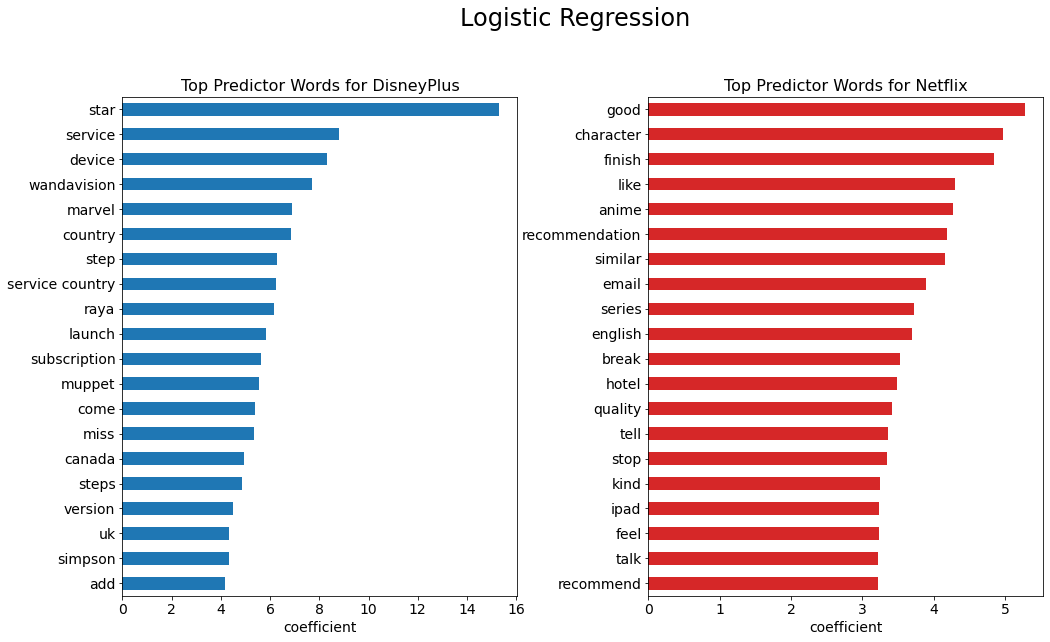

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10)) 
fig.tight_layout(pad=10.0)
fig.suptitle('Logistic Regression', fontsize=24)

# subplot for DisneyPlus
log_disney_coef.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:blue', ax=ax[0])
ax[0].set_title('Top Predictor Words for DisneyPlus', fontsize=16)
ax[0].tick_params('x', labelsize=14)
ax[0].tick_params('y', labelsize=14)
ax[0].set_xlabel('coefficient', fontsize=14)

# subplot for Netflix
log_netflix_coef.abs().sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:red', ax=ax[1])
ax[1].set_title('Top Predictor Words for Netflix', fontsize=16)
ax[1].tick_params('x', labelsize=14)
ax[1].tick_params('y', labelsize=14)
ax[1].set_xlabel('coefficient', fontsize=14);

Observations:
    
1) "Star" is a subservice within Disney Plus so it is a strong predictor for Disney posts. However it is also part of "Star Wars" and its spin-off "The Mandalorian". Hence removing the word "star" can impact the structure of other posts. 

2) Popular titles like 'Marvel", "Raya", "WandaVision", "Muppet" and "Frozen" are strong predictors for Disney post as expected. 

3) Once again, "service" and "service country" are strong predictors but also sources of dissatisfaction.

## Count Vectorizer and Naive Bayes Multinomial

In [76]:
pipe2 = Pipeline([
                ('cvec', CountVectorizer()),
                ('nb', MultinomialNB())
                 ])

In [77]:
# original grid search parameter commented out to reduce run time when reloading notebook
params2 = {
    'cvec__max_df': [0.80],
    # 'cvec__max_df': [0.80 ,0.90, 0.95, 1.00],
    'cvec__min_df': [0.00],
    # 'cvec__min_df': [0.00, 0.05, 0.10],
    'cvec__max_features': [None],
    #'cvec__max_features': [10000, 15000, 20000, None],
    'cvec__ngram_range': [(1,2)],
    # 'cvec__ngram_range': [(1,1),(1,2)],
    'nb__alpha': [3.5938136638046276]
    # 'nb__alpha': np.logspace(0,1,10),
}

In [78]:
gs2 = grid_tuning(pipe2, params2, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [79]:
model2 = gs2.best_estimator_

In [80]:
gs2.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': None,
 'cvec__min_df': 0.0,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 3.5938136638046276}

In [81]:
# save model 2
filename = './models/nbmulti.pkl'
pickle.dump(model2, open(filename, 'wb'))

**Evaluation**

In [82]:
# extract trained coefficients 
nbmulti_coefs = model2.named_steps.nb.feature_log_prob_
nbmulti_features = model2.named_steps.cvec.get_feature_names()

# create series
nbmulti_disney_coefs = pd.Series(np.exp(nbmulti_coefs[1]), index = nbmulti_features)
nbmulti_netflix_coefs = pd.Series(np.exp(nbmulti_coefs[0]), index = nbmulti_features)


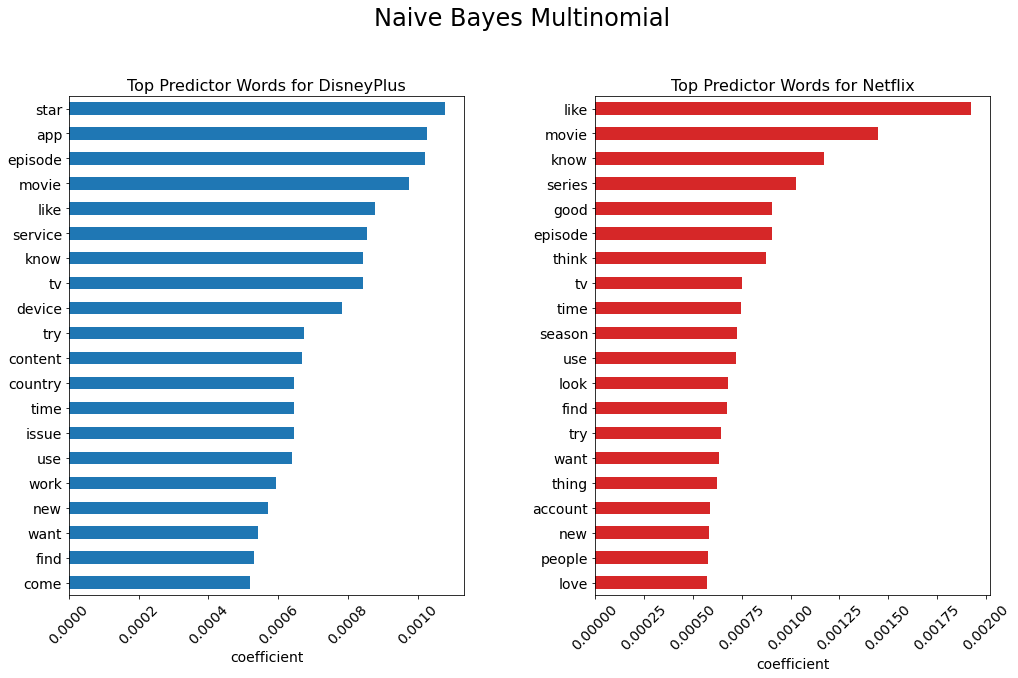

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10)) 
fig.tight_layout(pad=10.0)
fig.suptitle('Naive Bayes Multinomial', fontsize=24)

# subplot for Disney
nbmulti_disney_coefs.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:blue', ax=ax[0])
ax[0].set_title('Top Predictor Words for DisneyPlus', fontsize=16)
ax[0].tick_params('x', labelsize=14)
ax[0].tick_params('y', labelsize=14)
ax[0].set_xlabel('coefficient', fontsize=14)
ax[0].tick_params(axis='x', labelrotation=45)

# subplot for Netflix
nbmulti_netflix_coefs.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:red', ax=ax[1])
ax[1].set_title('Top Predictor Words for Netflix', fontsize=16)
ax[1].tick_params('x', labelsize=14)
ax[1].tick_params('y', labelsize=14)
ax[1].set_xlabel('coefficient', fontsize=14)
ax[1].tick_params(axis='x', labelrotation=45);

## TFIDF Vectorizer and Extra Trees Classifier

In [84]:
pipe3 = Pipeline([
                ('tvec', CountVectorizer()),
                ('ada', AdaBoostClassifier(base_estimator = ExtraTreesClassifier(),
                                                            random_state=42))
                 ])

In [85]:
# original grid search parameter commented out to reduce run time when reloading notebook
params3 = {
    'tvec__max_df': [0.80],
    #'tvec__max_df': [0.80 ,0.90, 0.95, 1.00],
    'tvec__min_df': [0.05],
    #  'tvec__min_df': [0.00, 0.05, 0.10],
    'tvec__max_features': [10000],
    # 'tvec__max_features': [10000, 15000, 20000, None],
    'tvec__ngram_range': [(1,1)],
    # 'tvec__ngram_range': [(1,1),(1,2)],
    'ada__base_estimator__max_depth': [10],
    # 'ada__base_estimator__max_depth': [5, 10, 20],

    'ada__base_estimator__n_estimators': [100],
    # 'ada__base_estimator__n_estimators': [50, 100, 150],
    'ada__n_estimators': [100],
    # 'ada__n_estimators': [50, 100, 150],
    'ada__learning_rate': [0.1],
    # 'ada__learning_rate': [0.1, 0.5, 1.0]
}

In [86]:
gs3 = grid_tuning(pipe3, params3, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


In [87]:
gs3.best_params_

{'ada__base_estimator__max_depth': 10,
 'ada__base_estimator__n_estimators': 100,
 'ada__learning_rate': 0.1,
 'ada__n_estimators': 100,
 'tvec__max_df': 0.8,
 'tvec__max_features': 10000,
 'tvec__min_df': 0.05,
 'tvec__ngram_range': (1, 1)}

In [88]:
model3 = gs3.best_estimator_

In [89]:
#save model3
filename = './models/et-ada.pkl'
pickle.dump(model3, open(filename, 'wb'))

In [90]:
# extract feature importance
et_coefs = model3.named_steps.ada.feature_importances_
et_features = model3.named_steps.tvec.get_feature_names()

In [91]:
# create series
et_coefs = pd.Series(et_coefs, index = et_features)

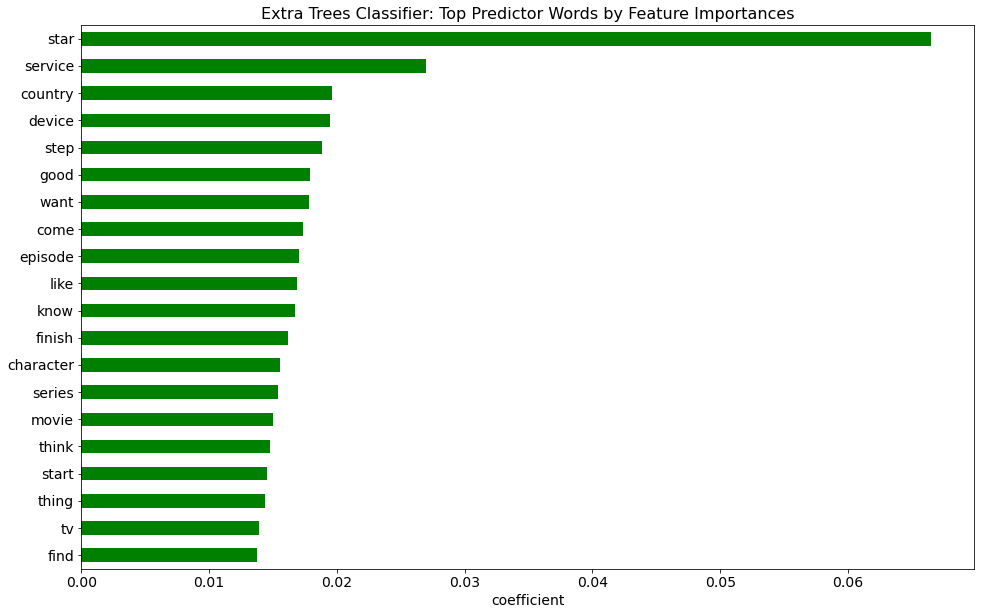

In [92]:
plt.figure(figsize=(16, 10)) 

et_coefs.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='green')
plt.title('Extra Trees Classifier: Top Predictor Words by Feature Importances', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('coefficient', fontsize=14);

## Model Evaluation 

**Metrics**

In [93]:
# load models 
infile1 = open('./models/logreg.pkl', 'rb')
trained1=pickle.load(infile1)

infile2 = open('./models/nbmulti.pkl', 'rb')
trained2=pickle.load(infile2)

infile3 = open('./models/et-ada.pkl', 'rb')
trained3=pickle.load(infile3)

In [94]:
# custom function to extract various classification metrics
def score_dict(model, X, y):
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    accu = accuracy_score(y, y_pred)
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    f1 = f1_score(y, y_pred)
    return {'accuracy': accu,
            'sensitivity': sens,
            'specificity': spec ,
            'F1': f1 }

In [95]:
# create dataframe to summary scores
score_array = []
model_names = ['log reg', 'naive bayes', 'extra trees']
models = [trained1, trained2, trained3]

for name, model in zip(model_names, models):
    score = score_dict(model, X_test, y_test)
    score['name'] = name
    score_array.append(score)
    
score_df = pd.DataFrame(score_array)
score_df = score_df[['name', 'accuracy','sensitivity','specificity','F1']]
score_df.set_index('name', inplace=True)

In [96]:
score_df.head()

,accuracy,sensitivity,specificity,F1
name,,,,
log reg,0.823077,0.713043,0.910345,0.780952
naive bayes,0.811538,0.704348,0.896552,0.767773
extra trees,0.734615,0.643478,0.806897,0.682028


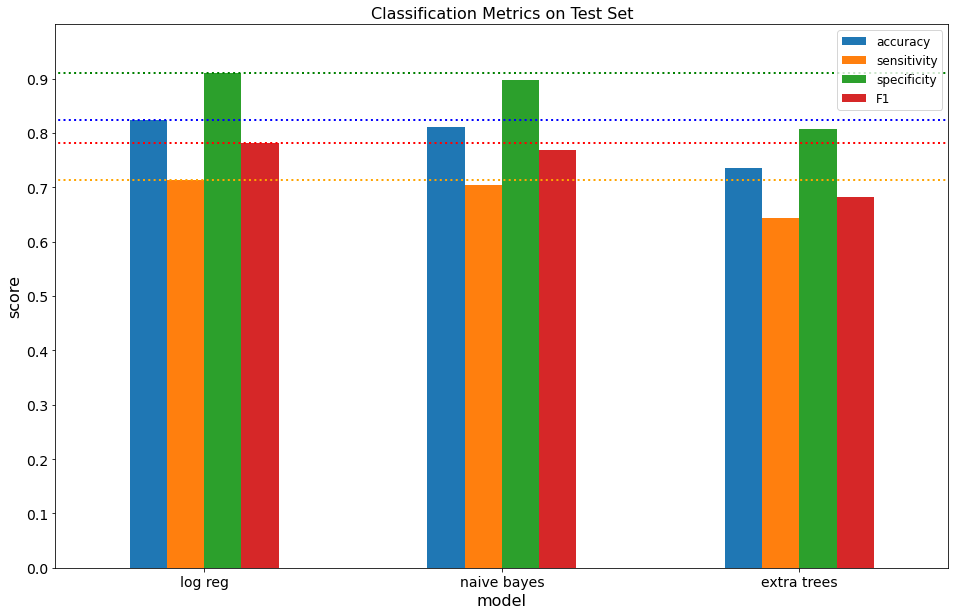

In [97]:
score_df.plot(kind='bar', figsize=(16,10))

plt.title('Classification Metrics on Test Set', fontsize=16)
plt.tick_params('x', labelsize=14)
plt.tick_params('y', labelsize=14)
plt.xlabel('model', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.ylim([0,1.0])
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(prop={'size': 12});
plt.xticks(rotation=0)

# annotate highest accuracy
plt.hlines(y=0.823077, xmin=-10,xmax=10, linestyle='dotted', colors='blue', lw = 2);
# annotate highest sensitivity
plt.hlines(y=0.713043, xmin=-10,xmax=10, linestyle='dotted', colors='orange', lw = 2);
# annotate highest specificity
plt.hlines(y=0.910345, xmin=-10,xmax=10, linestyle='dotted', colors='green', lw = 2);
# annotate highest f1
plt.hlines(y=0.780952, xmin=-10,xmax=10, linestyle='dotted', colors='red', lw = 2);
plt.savefig('test.jpg', dpi=150)

Observations:

1) Logistic Regression produced the highest scores in all 4 metrics.  F1 scores rise in tandem with the other metrics as both precision and recall rise as well. After hyperparameter tuning, the accuracy score on 1st set did not improve. 

2) The accuracy score on test set for Naive Bayes improved from 75.8% to 81.2% after hyperparameter tuning. This amounts to 70 posts out of 1300, which is sizeable improvement. 

2) Both Logistic Regression and Naive Bayes Classifiers have lower complexities compared to Extra Trees Classifier, resulting in lower processing and grid search time. Hence both have the edge in efficiencies. 

3) Extra Trees Classifier is likely over complicated for this task due to the very large number of features from the vocabulary. After the tuning, the results did not improve and much time was wasted in the process of grid search. With a 5 figure number of features, a much larger number of additional trees are required to train the model. Random search or Bayes optimization should be explored. 


**Confusion Matrix for Logistic Regression**

<Figure size 1008x1008 with 0 Axes>

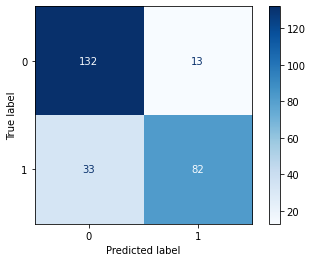

In [98]:
plt.figure(figsize=(14,14))
plot_confusion_matrix(trained1, X_test, y_test, cmap='Blues', values_format='d');

# Production Model with Full Data Set  : Logistic Regression 

The final model selected is logistic regression as the scores from this model were the highest across the board. 

## Scores

In [99]:
print('The accuracy on train set is {}%.'.format(100*round(trained1.score(X_train, y_train),4)))

The accuracy on train set is 100.0%.


In [100]:
print('The accuracy on test set is {}%.'.format(100*round(trained1.score(X_test, y_test),4)))

The accuracy on test set is 82.31%.


In [101]:
X = df['processed_text']
y = df['label']

In [102]:
print('The final accuracy on full data set is {}%.'.format(100*round(trained1.score(X,y),4)))

The final accuracy on full data set is 96.46000000000001%.


In [103]:
y_pred = trained2.predict(X)

df.loc[:,['prediction']]=y_pred

**Repeating the steps from Section 6.1**

In [104]:
# extract trained coefficients 
log_coefs = model1.named_steps.lr.coef_
log_features = model1.named_steps.tvec.get_feature_names()

# create series
log_coefs_df = pd.Series(log_coefs[0], index = log_features)

# filter positive coefficients for DisneyPlus
log_disney_coef = log_coefs_df[log_coefs_df > 0]

# filter negative coefficients for Netflix
log_netflix_coef = log_coefs_df[log_coefs_df < 0]


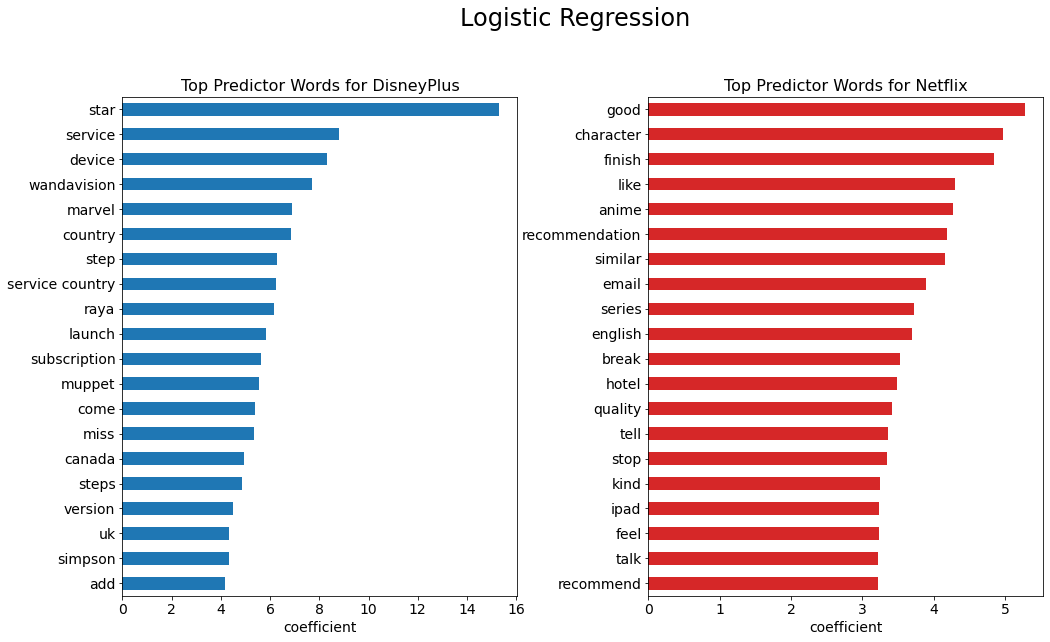

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10)) 
fig.tight_layout(pad=10.0)
fig.suptitle('Logistic Regression', fontsize=24)

# subplot for DisneyPlus
log_disney_coef.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:blue', ax=ax[0])
ax[0].set_title('Top Predictor Words for DisneyPlus', fontsize=16)
ax[0].tick_params('x', labelsize=14)
ax[0].tick_params('y', labelsize=14)
ax[0].set_xlabel('coefficient', fontsize=14)

# subplot for Netflix
log_netflix_coef.abs().sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:red', ax=ax[1])
ax[1].set_title('Top Predictor Words for Netflix', fontsize=16)
ax[1].tick_params('x', labelsize=14)
ax[1].tick_params('y', labelsize=14)
ax[1].set_xlabel('coefficient', fontsize=14);

Observations:

1) In logistic regression and tree classifier, strong predictor words carry larger coefficients or feature importances. Hence, it is easy to find popular titles ranked high in the bar plots for these 2 classifiers. 

2) On the other hand, words in naives bayes multinomial classifier are characterized by their probabilities computed simply by frequency within the entire corpus. As such, the top predictor words shown above are the most commonly written verbs and nouns. For this reason, show title or specific topic that distinguish the 2 subreddits do not appear high on the bar plot due to the much lower occurrence. 


## Misclassified Posts

In [106]:
filter_misclass = df['prediction'] != df['label']
df[filter_misclass]['subreddit'].value_counts()

DisneyPlus    43
netflix       28
Name: subreddit, dtype: int64

In [107]:
df[filter_misclass]

,subreddit,post,processed_text,num_words,polarity,sentiment,label,prediction
4,DisneyPlus,Mighty ducks game changers question I’ve yet to see this answered anywhere so...\n\nIs this going to be episodic (once per week) or all episodes for season 1 together? \n\nAnyone know?,mighty duck game changer question answer episodic week episode season know,31,0.000000,neutral,1,0
6,DisneyPlus,911 I am loving the show does anyone know at all when season 3 is being added,love know season add,17,0.600000,positive,1,0
14,DisneyPlus,"What are some good movies for adults on Disney Plus? I am currently watching Hidden Figures, but I am looking for more movies like Hidden Figures that have been blockbusters or otherwise good movies for adults made within the last 15 years.",good movie adult currently hide figure look movie like hidden figure blockbuster good movie adult year,42,0.223810,positive,1,0
21,DisneyPlus,"Change streaming quality for each profile I'll say it how it is: My internet is shit and there's nothing I can do about it! That's why my family only streams 1080p movies when we watch stuff together. If everyone's doing their own thing, then we just use 480p/720p out of courtesy. I set up one profile for each person and an extra one for the living room TV.\n\nIt's possibly to change the streaming quality in the ""app"" settings (4k, 1080p or 480p) but that seems to be the same setting for the whole account.\n\nHow do I change it individually, for each profile?\n\nWith Netflix it's possible set to the quality individually for each profile and no matter if you use the profile on your phone, the TV or even through the website/Windows app, it uses that quality. With Prime you can set the streaming quality directly (while the video's playing). Youtube: Well, all the settings you'd ever wish for! But how do I do this with Disney+? Do I really have to keep changing the setting: Increase the quality before we all want to watch stuff together, then decrease it again?",change streaming quality profile internet shit family stream movie stuff thing use courtesy set profile person extra living room tv possibly change streaming quality app setting setting account change individually profile possible set quality individually profile matter use profile phone tv website windows app use quality prime set streaming quality directly video playing youtube setting wish change setting increase quality want stuff decrease,193,0.072917,positive,1,0
45,DisneyPlus,"Lab Rats or Disney plus mistake I have noticed that lab Rats on disney plus is very messed up.\nEpisodes missing and the storytelling is all weird.\nIn one episode something happens, but in the next episode that didn't happen.\nMaby this is because of crossovers but still I can't get the whole story.\n\n\nAnd before you ask in the comments if I am a 5 year old who is asking his mom to type this, no I am 14 and I care for this because I never got to se all episodes as a kid.",lab rat mistake notice lab rat messed episode miss storytelling weird episode happen episode happen maby crossover story ask comment year old ask mom type care se episode kid,96,-0.033333,negative,1,0
...,...,...,...,...,...,...,...,...
1160,netflix,"Did the latest iOS update 13.15.0) break the app? Hi there\n\nI just updated my Netflix app on my iPad and on the iPhone (to version 13.15.0). When I open the app, it says “Network Error,” and I can’t play any shows or movies. The old version still plays fine on another iPad I own.\n\nIs anyone else experiencing the same?",late ios update break app hi update app ipad iphone version open app network error play movie old version play fine ipad experience,61,0.269444,positive,0,1
1189,netflix,"Turn off autoplay on AndroidTV finally I’ve contacted Netflix support about it several times. Of course without any response.\n\nPlease, can you fix this autoplay @&amp;#*$ in AndroidTV app for good.\n\nAnd NO, official instructions published on Netflix pages DOESN’T WORK. I’ve tried it at least

**Possible Reasons for Misclassification

1) Post does not contain subreddit specific words after removal from subreddit related key words, so prediction did not work well. The keywords include "Disney" and "Netflix, among others. 

2) Devices or software related words such as "Android", "iOS" and "Galaxy" mentioned are likely to be common to both subreddits, hence they are not well classified. 

3) Posts that do not contain any show title are not well classified by the model. 


# Brief Topic Modelling on DisneyPlus

In order to surface more discussion topics, I shall attempt some basic topic model using Latent Dirichlet Allocation. 

In [108]:
cvec = CountVectorizer()

In [109]:
disney_df = df[df['subreddit']=='DisneyPlus']['processed_text']
disney_cvec = cvec.fit_transform(disney_df)

In [110]:
# extract 5 topics from Disney
lda_dis = LatentDirichletAllocation(n_components = 5, random_state = 42)
lda_dis.fit(disney_cvec)

LatentDirichletAllocation(n_components=5, random_state=42)

In [111]:
for index, topic in enumerate(lda_dis.components_):
    print(f'Top 10 words for Topic #{index+1}')
    print([cvec.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 10 words for Topic #1
['continue', 'want', 'add', 'service', 'know', 'like', 'try', 'app', 'list', 'subtitle', 'content', 'movie', 'find', 'time', 'episode']


Top 10 words for Topic #2
['list', 'miss', 'week', 'film', 'premier', 'access', 'know', 'star', 'raya', 'come', 'title', 'release', 'like', 'season', 'episode']


Top 10 words for Topic #3
['account', 'find', 'hulu', 'think', 'service', 'come', 'season', 'subscription', 'new', 'know', 'change', 'content', 'like', 'movie', 'star']


Top 10 words for Topic #4
['release', 'spoiler', 'film', 'star', 'episode', 'new', 'use', 'like', 'know', 'channel', 'want', 'add', 'available', 'content', 'think']


Top 10 words for Topic #5
['log', 'screen', 'steps', 'episode', 'fix', 'play', 'step', 'work', 'try', 'country', 'issue', 'service', 'tv', 'device', 'app']




Observations: 

Topic #4 suggests discussion about service and device issues once again. 

# Conclusion

1) Many popular DisneyPlus titles, old and new, are the source of discussion among users which turned out to be top predictors in the classifier. In contrast, the individual titles do not stand out as top predictors for Netflix posts. 

2) Netflix produces a very range wide of content which may be the reason why the discussions are not centred about several titles. DisneyPlus can consider expanding beyond the crowd favourites in order to compete. 

3) From n-gram exploration data analysis among topic model, technical issues such as device compatibility, playback and customer service are surfaced and must be addressed in order to reduce customer attrition. 

**Suggestion for Further Analysis**
1) Refine unsupervised topic modeling on both subreddits to uncover more topics. 

2) Compare existing content catalogue with top positive predictor words from trained model to find more discussed titles among viewers. 

3) Fine tune trained Naive Bayes model by removing more words commmon to both subreddit classes. 
